## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Tobigs/week_6 Time-Series, NN Advanced/NN Advanced/과제/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Tobigs/week_6 Time-Series, NN Advanced/NN Advanced/과제/Test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

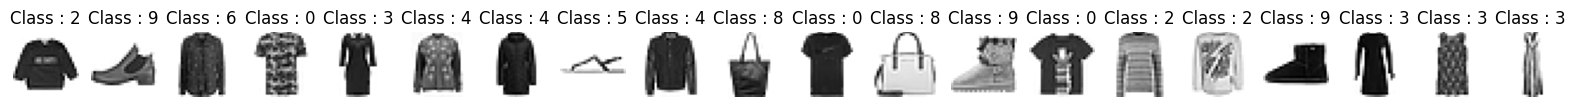

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

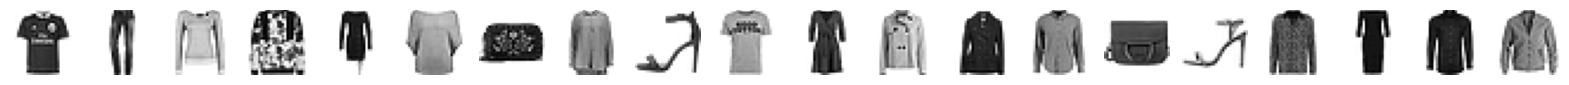

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [13]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [15]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

##cnn


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
    # 입력 데이터 x의 크기를 [batch_size, 784]에서 [batch_size, 1, 28, 28]로 변경
        x = x.view(-1, 1, 28, 28)
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 conv -> relu -> pool 적용
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 conv -> relu -> pool 적용
        x = x.view(-1, 64 * 7 * 7)  # 데이터를 평탄화
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# 모델 초기화 및 학습 준비
model_1 = CNN()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.4990, 	Train Accuracy: 81.78 %, 	Val Loss: 0.3240, 	Val Accuracy: 88.28 % 

[EPOCH: 2], 	Train Loss: 0.2990, 	Train Accuracy: 89.10 %, 	Val Loss: 0.3153, 	Val Accuracy: 88.58 % 

[EPOCH: 3], 	Train Loss: 0.2522, 	Train Accuracy: 90.63 %, 	Val Loss: 0.2743, 	Val Accuracy: 89.67 % 

[EPOCH: 4], 	Train Loss: 0.2149, 	Train Accuracy: 92.08 %, 	Val Loss: 0.2388, 	Val Accuracy: 91.04 % 

[EPOCH: 5], 	Train Loss: 0.1854, 	Train Accuracy: 93.28 %, 	Val Loss: 0.2304, 	Val Accuracy: 91.46 % 

[EPOCH: 6], 	Train Loss: 0.1594, 	Train Accuracy: 94.08 %, 	Val Loss: 0.2271, 	Val Accuracy: 91.83 % 

[EPOCH: 7], 	Train Loss: 0.1412, 	Train Accuracy: 94.72 %, 	Val Loss: 0.2478, 	Val Accuracy: 91.52 % 

[EPOCH: 8], 	Train Loss: 0.1165, 	Train Accuracy: 95.67 %, 	Val Loss: 0.2514, 	Val Accuracy: 91.37 % 

[EPOCH: 9], 	Train Loss: 0.1013, 	Train Accuracy: 96.23 %, 	Val Loss: 0.2706, 	Val Accuracy: 91.33 % 

[EPOCH: 10], 	Train Loss: 0.0818, 	Train Accuracy: 96.94 %, 	Val Loss: 0.

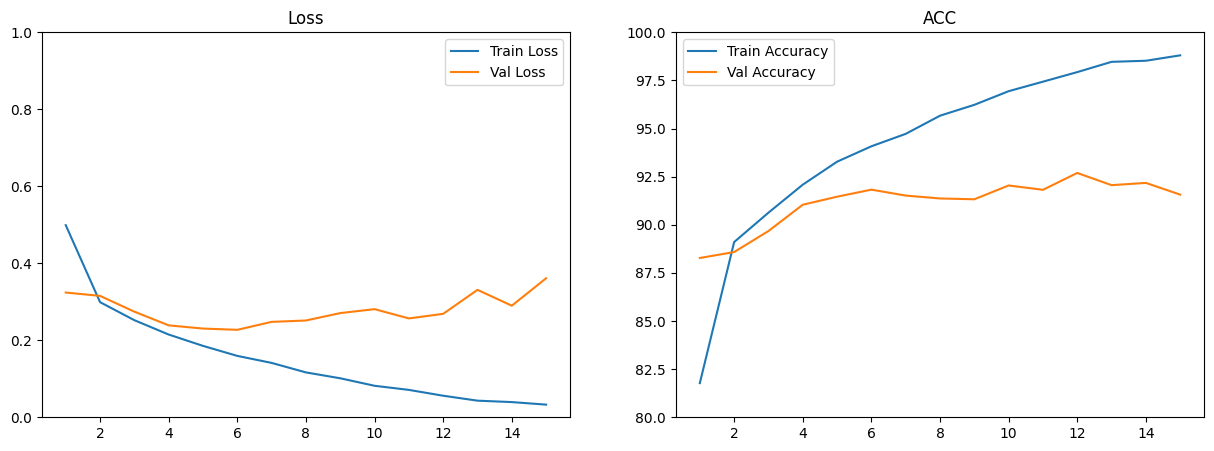

In [60]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  # 모델을 GPU로 이동
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_1.to(device)
  train_loss, train_accuracy = train(model_1, train_loader)
  val_loss, val_accuracy = evaluate(model_1, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

##ResNet

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# 모델 초기화 및 학습 준비
model_2 = ResNet18()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
class DataSet(Dataset):
  def __init__(self, image, label=None):
    super(DataSet, self).__init__()
    self._image = image.reshape((-1, 1, 28, 28))  # 이미지를 [batch_size, 1, 28, 28]로 변환
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image
    else:
      image = self._image[idx]
      label = self._label[idx]
      return image, label

In [24]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

[EPOCH: 1], 	Train Loss: 0.4269, 	Train Accuracy: 84.25 %, 	Val Loss: 0.3416, 	Val Accuracy: 88.16 % 

[EPOCH: 2], 	Train Loss: 0.2606, 	Train Accuracy: 90.46 %, 	Val Loss: 0.2433, 	Val Accuracy: 91.45 % 

[EPOCH: 3], 	Train Loss: 0.2128, 	Train Accuracy: 92.23 %, 	Val Loss: 0.2397, 	Val Accuracy: 91.48 % 

[EPOCH: 4], 	Train Loss: 0.1840, 	Train Accuracy: 93.47 %, 	Val Loss: 0.2499, 	Val Accuracy: 90.67 % 

[EPOCH: 5], 	Train Loss: 0.1512, 	Train Accuracy: 94.52 %, 	Val Loss: 0.2271, 	Val Accuracy: 91.96 % 

[EPOCH: 6], 	Train Loss: 0.1332, 	Train Accuracy: 95.12 %, 	Val Loss: 0.2207, 	Val Accuracy: 92.32 % 

[EPOCH: 7], 	Train Loss: 0.1122, 	Train Accuracy: 95.90 %, 	Val Loss: 0.2053, 	Val Accuracy: 93.19 % 

[EPOCH: 8], 	Train Loss: 0.0938, 	Train Accuracy: 96.57 %, 	Val Loss: 0.2740, 	Val Accuracy: 91.06 % 

[EPOCH: 9], 	Train Loss: 0.0706, 	Train Accuracy: 97.43 %, 	Val Loss: 0.2565, 	Val Accuracy: 92.22 % 

[EPOCH: 10], 	Train Loss: 0.0601, 	Train Accuracy: 97.80 %, 	Val Loss: 0.

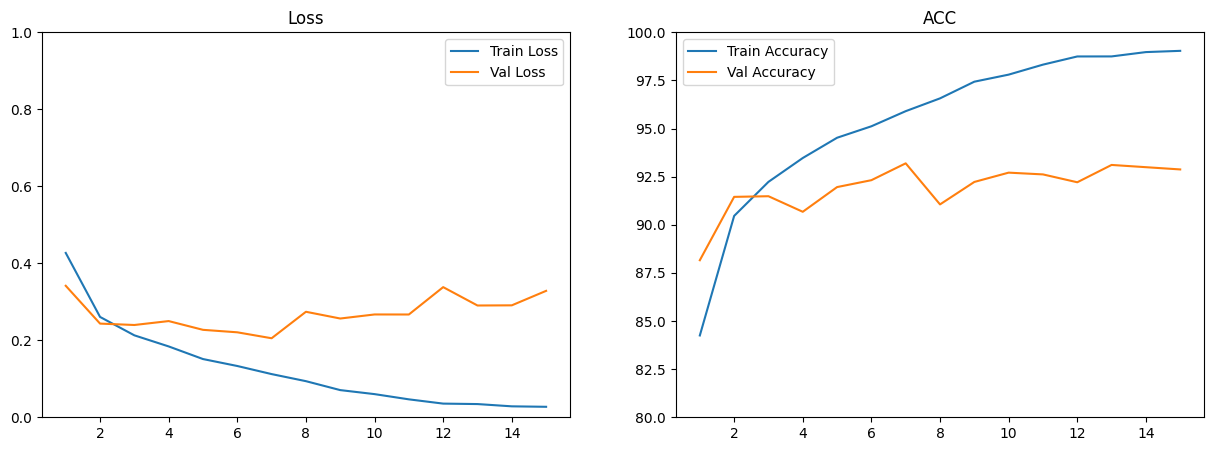

In [25]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  # 모델을 GPU로 이동
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_2.to(device)
  train_loss, train_accuracy = train(model_2, train_loader)
  val_loss, val_accuracy = evaluate(model_2, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:
- 기본 CNN 모델은 구현이 간단하고 계산 비용이 적은 반면, ResNet 모델은 더 복잡한 구조를 통해 높은 성능을 제공한다. 특히, ResNet 모델은 깊은 네트워크 구조를 통해 높은 정확도를 달성함으로써, 복잡한 이미지 분류 문제를 해결하는 데 더 적합한 선택이 될 수 있다.

- Adam과 Cross Entropy를 선택하여 사용하였다. 이러한 요소들은 모델이 빠르고 안정적으로 수렴하도록 도와주며, 복잡한 이미지 분류 작업에서 높은 정확도를 달성하는 데 필수적이다. 특히, ResNet같이 깊은 네트워크 구조와 복잡한 데이터셋에서의 학습에 있어서 이러한 기법들은 모델 성능을 극대화하는 데 중요한 역할을 한다.